## Essay Assessment and Feedback Generation Using LLM.

### Submitted By: Prathamesh Mohan Dharamthok. 
### Student ID: 20535214
### Course: MSc Data Science

This study is focused on leveraging LLM for IELTS Essay assessment and feedback generation. The data set used is available on Kaggle and is free to use.

Import required Packages and Libraries

In [ ]:
!pip install pyspark pandas openai transformers

Dataset Preprocessing:

In [6]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import pandas as pd
from transformers import pipeline

spark = SparkSession.builder.appName("IELTS Essay Scoring").getOrCreate()

file_path = "C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)


df.show()

df.printSchema()

df_clean = df.dropna()

def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text


clean_text_udf = udf(clean_text, StringType())


df_clean = df_clean.withColumn('cleaned_essay', clean_text_udf(col('essay')))


df_clean.select('essay', 'cleaned_essay')


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------+
|           Task_Type|            Question|               Essay|     Examiner_Commen|       Task_Response|  Coherence_Cohesion|    Lexical_Resource|      Range_Accuracy|Overall|Feedback|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------+
|                   1|The bar chart bel...|Between 1995 and ...|                NULL|                NULL|                NULL|                NULL|                NULL|    5.5|    NULL|
|                   2|Rich countries of...|Poverty represent...|                NULL|                NULL|                NULL|                NULL|                NULL|    6.5|    NULL|
|                   1|The bar chart bel...|The left chart sh...| 

DataFrame[essay: string, cleaned_essay: string]

## BART model for Grammar Accuracy Calculations:

In [9]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import openpyxl

df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')


df_subset = df.head(5)

model_name = "facebook/bart-base"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


def assess_grammar(essay):
  
  input_ids = tokenizer(essay, return_tensors="pt")["input_ids"]

  
  output = model.generate(
      input_ids=input_ids,
      max_length=512,  
      num_beams=4,  
      no_repeat_ngram_size=2,  
      early_stopping=True  
  )

  
  corrected_essay = tokenizer.decode(output[0], skip_special_tokens=True)

  score = len(set(essay.split()) ^ set(corrected_essay.split()))

  
  normalized_score = normalize_score(score, max_edits=100)  

  
  final_score = normalized_score  

  return final_score


def normalize_score(edit_count, max_edits):
  if edit_count == 0:
    return 9  
  return 9 * (1 - edit_count / max_edits)  



df_subset['grammar_score'] = df_subset['Essay'].apply(assess_grammar)


print(df_subset[['Question', 'Essay', 'grammar_score']].head(5))  



                                            Question  \
0  The bar chart below describes some changes abo...   
1  Rich countries often give money to poorer coun...   
2  The bar chart below describes some changes abo...   
3  Rich countries often give money to poorer coun...   
4  The graph below shows the number of overseas v...   

                                               Essay  grammar_score  
0  Between 1995 and 2010, a study was conducted r...           4.77  
1  Poverty represents a worldwide crisis. It is t...           3.15  
2  The left chart shows the population change hap...           3.78  
3  Human beings are facing many challenges nowada...           2.07  
4  Information about the thousands of visits from...           4.86  


C:\Users\LLR User\AppData\Local\Temp\ipykernel_13496\3771393991.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['grammar_score'] = df_subset['Essay'].apply(assess_grammar)


Save results in Excel File:

In [ ]:
df_subset.to_excel('grammar_assessment_resultsnew.xlsx', index=False)

print(f"Grammar scores saved to 'grammar_assessment_resultsnew.xlsx'")

## LLama Model:

First Login to Hugging Face account which is having access to LLama Model

In [ ]:
!huggingface-cli login

Try to Load the Model: The Kernel Crashes due to Out of Memory Error.

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM
 
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")

### GPT Models:

GPT-3.5-Turbo Model to assess grammar.

To run GPT models, An open api key is necessary. This can be generated on the openapi platform.

In [ ]:
import pandas as pd
import openai 


df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')


df_gpt = df.head(5)

# # Input your api key here!, The key has been removed due to privacy issue. 
openai.api_key = '   ' 


def assess_grammar(Essay):
    prompt = f"Suppose you are an IELTS examiner, assess the grammar of the following essay on a scale of 1 to 9:\n{Essay}\n---\nGrammar score:"
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": prompt}
        ],
        max_tokens=50,
        stop=["\n"]
    )
    return response['choices'][0]['message']['content'].strip()


df_gpt['grammar_score'] = df_gpt['Essay'].apply(assess_grammar)


print(df_gpt[['Question', 'Essay', 'grammar_score']])

GPT-4o-mini for overall assessment:

In [ ]:
import pandas as pd
import openai
import re


df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')



df_gptmini = df[['Question', 'Essay']].iloc[500:505]

# Input your api key here!
openai.api_key = '  '


def assess_essay(Essay):
    prompt = f"""
    You are an IELTS examiner. Assess the following essay based on the IELTS Writing Task 1 criteria. Provide only a score out of 9 for each criterion, use IELTS marking pattern to assess the scores, and then provide an Overall Band Score. 
    Ensure to provide a short feedback about the overall essay.

    Essay:
    {Essay}

    ---
    Coherence and Cohesion score: 
    Task Achievement score: 
    Lexical Resource score: 
    Grammatical Range and Accuracy score: 
    Overall Band Score: 
    Detailed Feedback: 
    """
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        max_tokens=500
    )
    
    
    raw_response = response['choices'][0]['message']['content'].strip()
    
    
    scores_and_feedback = {
        "Coherence and Cohesion": "Not Provided",
        "Task Achievement": "Not Provided",
        "Lexical Resource": "Not Provided",
        "Grammatical Range and Accuracy": "Not Provided",
        "Overall Band Score": "Not Provided",
        "Detailed Feedback": "Not Provided"
    }
    
    
    coherence_match = re.search(r'Coherence and Cohesion score:\s*(\d+)', raw_response)
    task_match = re.search(r'Task Achievement score:\s*(\d+)', raw_response)
    lexical_match = re.search(r'Lexical Resource score:\s*(\d+)', raw_response)
    grammar_match = re.search(r'Grammatical Range and Accuracy score:\s*(\d+)', raw_response)
    overall_match = re.search(r'Overall Band Score:\s*(\d+)', raw_response)
    feedback_match = re.search(r'Detailed Feedback:\s*(.*)', raw_response, re.DOTALL)
    
    if coherence_match:
        scores_and_feedback["Coherence and Cohesion"] = coherence_match.group(1)
    if task_match:
        scores_and_feedback["Task Achievement"] = task_match.group(1)
    if lexical_match:
        scores_and_feedback["Lexical Resource"] = lexical_match.group(1)
    if grammar_match:
        scores_and_feedback["Grammatical Range and Accuracy"] = grammar_match.group(1)
    if overall_match:
        scores_and_feedback["Overall Band Score"] = overall_match.group(1)
    if feedback_match:
        scores_and_feedback["Detailed Feedback"] = feedback_match.group(1).strip()
    
    return scores_and_feedback


df_scores = df_gptmini ['Essay'].apply(assess_essay).apply(pd.Series)


df_gptmini   = pd.concat([df_gptmini  , df_scores], axis=1)


print(df_gptmini [['Question', 'Essay', 'Coherence and Cohesion', 'Task Achievement', 'Lexical Resource', 'Grammatical Range and Accuracy', 'Overall Band Score', 'Detailed Feedback']])

Save the results to Excel file:

In [ ]:
df_gptmini.to_excel('GPT4oAssessment_results3.xlsx', index=False)

print(f"Grammar scores saved to 'GPT4oAssessment_results3.xlsx'")

## Fine tuning GPT-3.5 turbo

Generating json files for fine tuning:

In [ ]:
import pandas as pd
import json
import openai


df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')


train_df = df[['Question', 'Essay', 'Overall']].head(500)
test_df = df[['Question', 'Essay', 'Overall']].tail(50)


def convert_to_jsonl_gpt_35(df, file_name):
    data = []
    for _, row in df.iterrows():
        messages = [
            {"role": "system", "content": "You are an IELTS examiner assessing essays."},
            {"role": "user", "content": f"Essay text:\n{row['Essay']}\n---\nOverall Band Score:"},
            {"role": "assistant", "content": f"{row['Overall']}"}
        ]
        data.append({"messages": messages})
    
    
    with open(file_name, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item) + "\n")


convert_to_jsonl_gpt_35(train_df, 'training_data_gpt_35.jsonl')
convert_to_jsonl_gpt_35(test_df, 'testing_data_gpt_35.jsonl')

# Input your api key here!
openai.api_key = '  '


def upload_file(file_path):
    response = openai.File.create(
        file=open(file_path, 'rb'),
        purpose='fine-tune'
    )
    return response['id']


training_file_id = upload_file('training_data_gpt_35.jsonl')
testing_file_id = upload_file('testing_data_gpt_35.jsonl')

print(f"Training file ID: {training_file_id}")
print(f"Testing file ID: {testing_file_id}")


with open('training_data_gpt_35.jsonl', 'r', encoding='utf-8') as f:
    for i in range(5):
        print(f.readline().strip())

with open('testing_data_gpt_35.jsonl', 'r', encoding='utf-8') as f:
    for i in range(5):
        print(f.readline().strip())


Fine tuning Job was created on OpenAI API Platform.

Fine tuning job got successfull and we got the first Fine Tuned Model

First Fined tuned model: ft:gpt-3.5-turbo-0125:personal:pdllm:9oA4XJQh

In [ ]:
import pandas as pd
import openai
import re


df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')


df_dataFineTuned = df[['Question', 'Essay', 'Overall']].iloc[1200:1210]

# Input your api key here!
openai.api_key = '  '


def assess_essay(Essay):
    prompt = f"""
    You are an IELTS examiner. Assess the following essay based on the IELTS Writing Task 1 criteria. Provide only a score out of 9 for each criterion, use IELTS marking pattern to assess the scores, and then provide an Overall Band Score. 
    Ensure to provide a short feedback about the overall essay.

    Essay:
    {Essay}

    ---
    Coherence and Cohesion score: 
    Task Achievement score: 
    Lexical Resource score: 
    Grammatical Range and Accuracy score: 
    Overall Band Score: 
    Detailed Feedback: 
    """
    response = openai.ChatCompletion.create(
        model="ft:gpt-3.5-turbo-0125:personal:pdllm:9oA4XJQh",
        messages=[
            {"role": "system", "content": prompt}
        ],
        max_tokens=500
    )
    
    
    raw_response = response['choices'][0]['message']['content'].strip()
    
    
    scores_and_feedback = {
        "Coherence and Cohesion": "Not Provided",
        "Task Achievement": "Not Provided",
        "Lexical Resource": "Not Provided",
        "Grammatical Range and Accuracy": "Not Provided",
        "Overall Band Score": "Not Provided",
        "Detailed Feedback": "Not Provided"
    }
    
    
    coherence_match = re.search(r'Coherence and Cohesion score:\s*(\d+(?:\.\d+)?)', raw_response)
    task_match = re.search(r'Task Achievement score:\s*(\d+(?:\.\d+)?)', raw_response)
    lexical_match = re.search(r'Lexical Resource score:\s*(\d+(?:\.\d+)?)', raw_response)
    grammar_match = re.search(r'Grammatical Range and Accuracy score:\s*(\d+(?:\.\d+)?)', raw_response)
    overall_match = re.search(r'Overall Band Score:\s*(\d+(?:\.\d+)?)', raw_response)
    feedback_match = re.search(r'Detailed Feedback:\s*(.*)', raw_response, re.DOTALL)
    
    if coherence_match:
        scores_and_feedback["Coherence and Cohesion"] = coherence_match.group(1)
    if task_match:
        scores_and_feedback["Task Achievement"] = task_match.group(1)
    if lexical_match:
        scores_and_feedback["Lexical Resource"] = lexical_match.group(1)
    if grammar_match:
        scores_and_feedback["Grammatical Range and Accuracy"] = grammar_match.group(1)
    if overall_match:
        scores_and_feedback["Overall Band Score"] = overall_match.group(1)
    if feedback_match:
        scores_and_feedback["Detailed Feedback"] = feedback_match.group(1).strip()
    
    return scores_and_feedback


df_scores = df_dataFineTuned['Essay'].apply(assess_essay).apply(pd.Series)


df_dataFineTuned = pd.concat([df_dataFineTuned, df_scores], axis=1)


print(df_dataFineTuned[['Question', 'Essay', 'Coherence and Cohesion', 'Task Achievement', 'Lexical Resource', 'Grammatical Range and Accuracy', 'Overall Band Score', 'Detailed Feedback']])


Save results to excel:

In [ ]:
df_dataFineTuned.to_excel('Finetunedmodel_results2.xlsx', index=False)

print(f"Grammar scores saved to 'Finetunedmodel_results2.xlsx.xlsx'")

New fine tuning model - 2nd fine tuned model: 1200 training 50 testing

Creating Json files for fine tuning.

In [ ]:
import pandas as pd
import json
import openai


df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')


train_df = df[['Question', 'Essay', 'Overall']].head(1200)
test_df = df[['Question', 'Essay', 'Overall']].tail(50)


def convert_to_jsonl_gpt_4o(df, file_name):
    data = []
    for _, row in df.iterrows():
        messages = [
            {"role": "system", "content": "You are an IELTS examiner assessing essays. Provide an overall score for the essay"},
            {"role": "user", "content": f"Essay text:\n{row['Essay']}\n---\nOverall Band Score:"},
            {"role": "assistant", "content": f"{row['Overall']}"}
        ]
        data.append({"messages": messages})
    
    
    with open(file_name, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item) + "\n")


convert_to_jsonl_gpt_4o(train_df, 'training_data_gpt_4o.jsonl')
convert_to_jsonl_gpt_4o(test_df, 'testing_data_gpt_4o.jsonl')

# Input your own api key
openai.api_key = '  '


def upload_file(file_path):
    response = openai.File.create(
        file=open(file_path, 'rb'),
        purpose='fine-tune'
    )
    return response['id']


training_file_id = upload_file('training_data_gpt_4o.jsonl')
testing_file_id = upload_file('testing_data_gpt_4o.jsonl')

print(f"Training file ID: {training_file_id}")
print(f"Testing file ID: {testing_file_id}")


with open('training_data_gpt_4o.jsonl', 'r', encoding='utf-8') as f:
    for i in range(5):
        print(f.readline().strip())

with open('testing_data_gpt_4o.jsonl', 'r', encoding='utf-8') as f:
    for i in range(5):
        print(f.readline().strip())

2nd fine tuned model: ft:gpt-3.5-turbo-0125:personal:pd-2nd-finetuning:9s9qgYSG

In [ ]:
import pandas as pd
import openai
import re

df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')


df_2ndFinetune = df[['Question', 'Essay', 'Overall']].iloc[1414:1422]

# Input your api key here!
openai.api_key = '  '


def assess_essay(Question, Essay):
    prompt = f"""
    You are an experienced IELTS examiner. Assess the following essay. Use IELTS marking pattern to assess the scores and then provide an Overall Band Score. 
    Ensure to provide a short feedback about the overall essay.

    Question:
    {Question}

    Essay:
    {Essay}

    ---
    Coherence and Cohesion score: 
    Task Achievement score: 
    Lexical Resource score: 
    Grammatical Range and Accuracy score: 
    Overall Band Score: 
    Detailed Feedback: 
    """
    response = openai.ChatCompletion.create(
        model="ft:gpt-3.5-turbo-0125:personal:pd-2nd-finetuning:9s9qgYSG",
        messages=[
            {"role": "system", "content": prompt}
        ],
        max_tokens=500
    )
    
    
    raw_response = response['choices'][0]['message']['content'].strip()
    
    
    scores_and_feedback = {
        "Coherence and Cohesion": "Not Provided",
        "Task Achievement": "Not Provided",
        "Lexical Resource": "Not Provided",
        "Grammatical Range and Accuracy": "Not Provided",
        "Overall Band Score": "Not Provided",
        "Detailed Feedback": "Not Provided"
    }
    
    
    coherence_match = re.search(r'Coherence and Cohesion score:\s*(\d+(?:\.\d+)?)', raw_response)
    task_match = re.search(r'Task Achievement score:\s*(\d+(?:\.\d+)?)', raw_response)
    lexical_match = re.search(r'Lexical Resource score:\s*(\d+(?:\.\d+)?)', raw_response)
    grammar_match = re.search(r'Grammatical Range and Accuracy score:\s*(\d+(?:\.\d+)?)', raw_response)
    overall_match = re.search(r'Overall Band Score:\s*(\d+(?:\.\d+)?)', raw_response)
    feedback_match = re.search(r'Detailed Feedback:\s*(.*)', raw_response, re.DOTALL)
    
    if coherence_match:
        scores_and_feedback["Coherence and Cohesion"] = coherence_match.group(1)
    if task_match:
        scores_and_feedback["Task Achievement"] = task_match.group(1)
    if lexical_match:
        scores_and_feedback["Lexical Resource"] = lexical_match.group(1)
    if grammar_match:
        scores_and_feedback["Grammatical Range and Accuracy"] = grammar_match.group(1)
    if overall_match:
        scores_and_feedback["Overall Band Score"] = overall_match.group(1)
    if feedback_match:
        scores_and_feedback["Detailed Feedback"] = feedback_match.group(1).strip()
    
    return scores_and_feedback


df_scores = df_2ndFinetune.apply(lambda row: assess_essay(row['Question'], row['Essay']), axis=1).apply(pd.Series)


df_2ndFinetune = pd.concat([df_2ndFinetune, df_scores], axis=1)


df_2ndFinetune['Overall Band Score'] = df_2ndFinetune['Overall Band Score'].astype(float)
accuracy = (df_2ndFinetune['Overall Band Score'] == df_2ndFinetune['Overall']).mean() * 100


print(f"Accuracy: {accuracy:.2f}%")


print(df_2ndFinetune[['Question', 'Essay', 'Coherence and Cohesion', 'Task Achievement', 'Lexical Resource', 'Grammatical Range and Accuracy', 'Overall Band Score', 'Overall', 'Detailed Feedback']])


Save results to excel file:

In [ ]:
df_2ndFinetune.to_excel('Finetunedmodel2_results-80%.xlsx', index=False)

print(f"Grammar scores saved to 'Finetunedmodel2_results-80%.xlsx'")

For Accuracy and QWK metric calculataions:

In [ ]:
!pip install scikit-learn
from sklearn.metrics import cohen_kappa_score

In [ ]:
import pandas as pd
import openai
import re
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error, r2_score, precision_score, f1_score


df = pd.read_csv('C:/Users/LLR User/Downloads/LLM Disseratation/ielts_writing_dataset.csv/ielts_writing_dataset.csv')


df_2ndFinetune1 = df[['Question', 'Essay', 'Overall']].iloc[1414:1424]

# Input your api key here!
openai.api_key = '  '


def assess_essay(Question, Essay):
    prompt = f"""
    You are an IELTS examiner. Assess the following essay. Use IELTS marking pattern to assess the scores and then provide an Overall Band Score. 
    Ensure to provide a short feedback about the overall essay.

    Question:
    {Question}

    Essay:
    {Essay}

    ---
    Coherence and Cohesion score: 
    Task Achievement score: 
    Lexical Resource score: 
    Grammatical Range and Accuracy score: 
    Overall Band Score: 
    Detailed Feedback: 
    """
    response = openai.ChatCompletion.create(
        model="ft:gpt-3.5-turbo-0125:personal:pd-2nd-finetuning:9s9qgYSG",
        messages=[
            {"role": "system", "content": prompt}
        ],
        max_tokens=500
    )
    
    
    raw_response = response['choices'][0]['message']['content'].strip()
    
    
    scores_and_feedback = {
        "Coherence and Cohesion": "Not Provided",
        "Task Achievement": "Not Provided",
        "Lexical Resource": "Not Provided",
        "Grammatical Range and Accuracy": "Not Provided",
        "Overall Band Score": "Not Provided",
        "Detailed Feedback": "Not Provided"
    }
    
   
    coherence_match = re.search(r'Coherence and Cohesion score:\s*(\d+(?:\.\d+)?)', raw_response)
    task_match = re.search(r'Task Achievement score:\s*(\d+(?:\.\d+)?)', raw_response)
    lexical_match = re.search(r'Lexical Resource score:\s*(\d+(?:\.\d+)?)', raw_response)
    grammar_match = re.search(r'Grammatical Range and Accuracy score:\s*(\d+(?:\.\d+)?)', raw_response)
    overall_match = re.search(r'Overall Band Score:\s*(\d+(?:\.\d+)?)', raw_response)
    feedback_match = re.search(r'Detailed Feedback:\s*(.*)', raw_response, re.DOTALL)
    
    if coherence_match:
        scores_and_feedback["Coherence and Cohesion"] = coherence_match.group(1)
    if task_match:
        scores_and_feedback["Task Achievement"] = task_match.group(1)
    if lexical_match:
        scores_and_feedback["Lexical Resource"] = lexical_match.group(1)
    if grammar_match:
        scores_and_feedback["Grammatical Range and Accuracy"] = grammar_match.group(1)
    if overall_match:
        scores_and_feedback["Overall Band Score"] = overall_match.group(1)
    if feedback_match:
        scores_and_feedback["Detailed Feedback"] = feedback_match.group(1).strip()
    
    return scores_and_feedback


df_scores = df_2ndFinetune1.apply(lambda row: assess_essay(row['Question'], row['Essay']), axis=1).apply(pd.Series)


df_2ndFinetune1 = pd.concat([df_2ndFinetune1, df_scores], axis=1)


df_2ndFinetune1['Overall Band Score'] = df_2ndFinetune1['Overall Band Score'].astype(float)
df_2ndFinetune1['Overall'] = df_2ndFinetune1['Overall'].astype(float)


df_2ndFinetune1['Overall Band Score'] = df_2ndFinetune1['Overall Band Score'].astype(float)
accuracy = (df_2ndFinetune1['Overall Band Score'] == df_2ndFinetune1['Overall']).mean() * 100


print(f"Accuracy: {accuracy:.2f}%")



df_2ndFinetune1['Overall Band Score Discrete'] = df_2ndFinetune1['Overall Band Score'].round().astype(int)
df_2ndFinetune1['Overall Discrete'] = df_2ndFinetune1['Overall'].round().astype(int)


qwk_score = cohen_kappa_score(df_2ndFinetune1['Overall Band Score Discrete'], df_2ndFinetune1['Overall Discrete'], weights='quadratic')


pearson_corr = df_2ndFinetune1[['Overall Band Score', 'Overall']].corr().iloc[0, 1]


mse = mean_squared_error(df_2ndFinetune1['Overall Band Score'], df_2ndFinetune1['Overall'])


mae = mean_absolute_error(df_2ndFinetune1['Overall Band Score'], df_2ndFinetune1['Overall'])


precision = precision_score(df_2ndFinetune1['Overall Discrete'], df_2ndFinetune1['Overall Band Score Discrete'], average='weighted', zero_division=0)
f1 = f1_score(df_2ndFinetune1['Overall Discrete'], df_2ndFinetune1['Overall Band Score Discrete'], average='weighted', zero_division=0)


print(f"Quadratic Weighted Kappa (QWK): {qwk_score:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


print(df_2ndFinetune1[['Question', 'Essay', 'Coherence and Cohesion', 'Task Achievement', 'Lexical Resource', 'Grammatical Range and Accuracy', 'Overall Band Score', 'Overall', 'Overall Band Score Discrete', 'Overall Discrete', 'Detailed Feedback']])


Final results:

Model: First Fine-Tuned Model	  Accuracy	60%	    QWK 0.75

Model: Second Fine-Tuned Model	  Accuracy	90%	    QWK 0.91



## Visualization

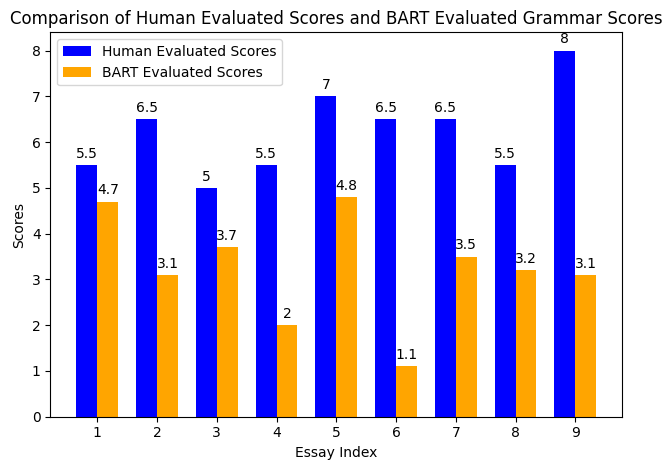

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Human evaluated overall scores
human_scores = [5.5, 6.5, 5, 5.5, 7, 6.5, 6.5, 5.5, 8]

# BART evaluated grammar scores
bart_scores = [4.7, 3.1, 3.7, 2.0, 4.8, 1.1, 3.5, 3.2, 3.1]

# Plotting the comparison
x = np.arange(len(human_scores))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, human_scores, width, label='Human Evaluated Scores', color='blue')
rects2 = ax.bar(x + width/2, bart_scores, width, label='BART Evaluated Scores', color='orange')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Essay Index')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Human Evaluated Scores and BART Evaluated Grammar Scores')
ax.set_xticks(x)
ax.set_xticklabels([str(i+1) for i in x])
ax.legend()

# Adding the values on top of the bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


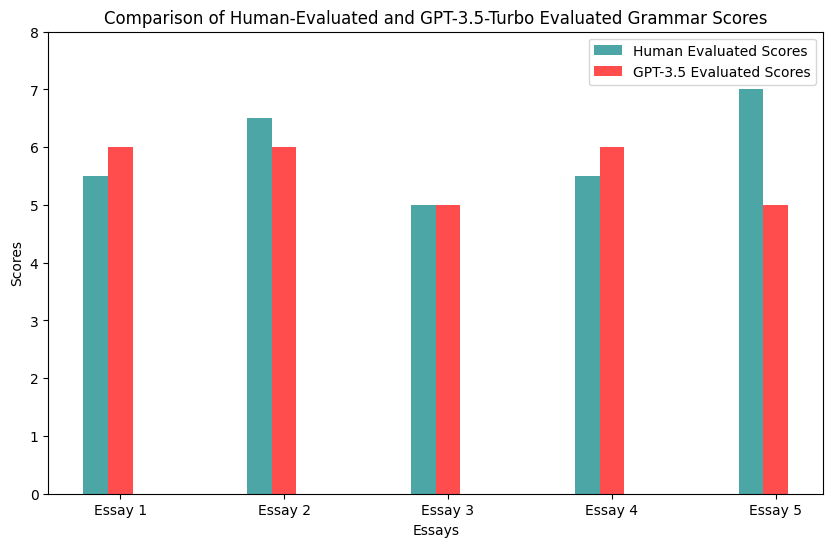

In [3]:
import matplotlib.pyplot as plt

# Data
human_scores = [5.5, 6.5, 5, 5.5, 7]
gpt_scores = [6, 6, 5, 6, 5]

# Labels for the essays
essay_labels = ['Essay 1', 'Essay 2', 'Essay 3', 'Essay 4', 'Essay 5']

# Plotting the bar graph
x = range(len(human_scores))
width = 0.15  # width of the bars

plt.figure(figsize=(10, 6))
plt.bar([p - width/2 for p in x], human_scores, width, label='Human Evaluated Scores', color='teal', alpha=0.7)
plt.bar([p + width/2 for p in x], gpt_scores, width, label='GPT-3.5 Evaluated Scores', color='red', alpha=0.7)


# Adding labels and title
plt.xlabel('Essays')
plt.ylabel('Scores')
plt.title('Comparison of Human-Evaluated and GPT-3.5-Turbo Evaluated Grammar Scores')
plt.xticks([p + width/2 for p in x], essay_labels)
plt.ylim([0, 8])

# Adding legend
plt.legend()

# Display the graph
plt.show()


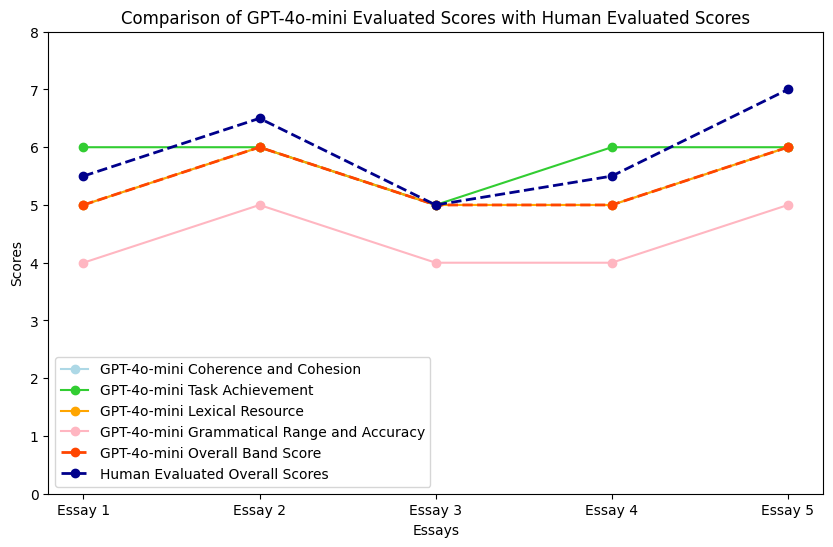

In [5]:
import matplotlib.pyplot as plt

# GPT-4o-mini evaluated scores
gpt_scores = {
    'Coherence and Cohesion': [5, 6, 5, 5, 6],
    'Task Achievement': [6, 6, 5, 6, 6],
    'Lexical Resource': [5, 6, 5, 5, 6],
    'Grammatical Range and Accuracy': [4, 5, 4, 4, 5],
    'Overall Band Score': [5, 6, 5, 5, 6]
}

# Human evaluated overall scores
human_scores = [5.5, 6.5, 5, 5.5, 7]

# Plotting the line graph for comparison
plt.figure(figsize=(10, 6))

# Plot each GPT-4o-mini score category with light colors
plt.plot(gpt_scores['Coherence and Cohesion'], marker='o', color='#ADD8E6', label='GPT-4o-mini Coherence and Cohesion')
plt.plot(gpt_scores['Task Achievement'], marker='o', color='#32CD32', label='GPT-4o-mini Task Achievement')
plt.plot(gpt_scores['Lexical Resource'], marker='o', color='#FFA500', label='GPT-4o-mini Lexical Resource')
plt.plot(gpt_scores['Grammatical Range and Accuracy'], marker='o', color='#FFB6C1', label='GPT-4o-mini Grammatical Range and Accuracy')

# Plot overall scores with dark colors
plt.plot(gpt_scores['Overall Band Score'], marker='o',linestyle='--', color='#FF4500', label='GPT-4o-mini Overall Band Score', linewidth=2)
plt.plot(human_scores, marker='o', linestyle='--', color='#00008B', label='Human Evaluated Overall Scores', linewidth=2)

# Adding labels and title
plt.xlabel('Essays')
plt.ylabel('Scores')
plt.title('Comparison of GPT-4o-mini Evaluated Scores with Human Evaluated Scores')
plt.xticks(range(5), ['Essay 1', 'Essay 2', 'Essay 3', 'Essay 4', 'Essay 5'])
plt.ylim(0, 8)

# Add legend
plt.legend(loc='best')

# Display the plot
plt.show()


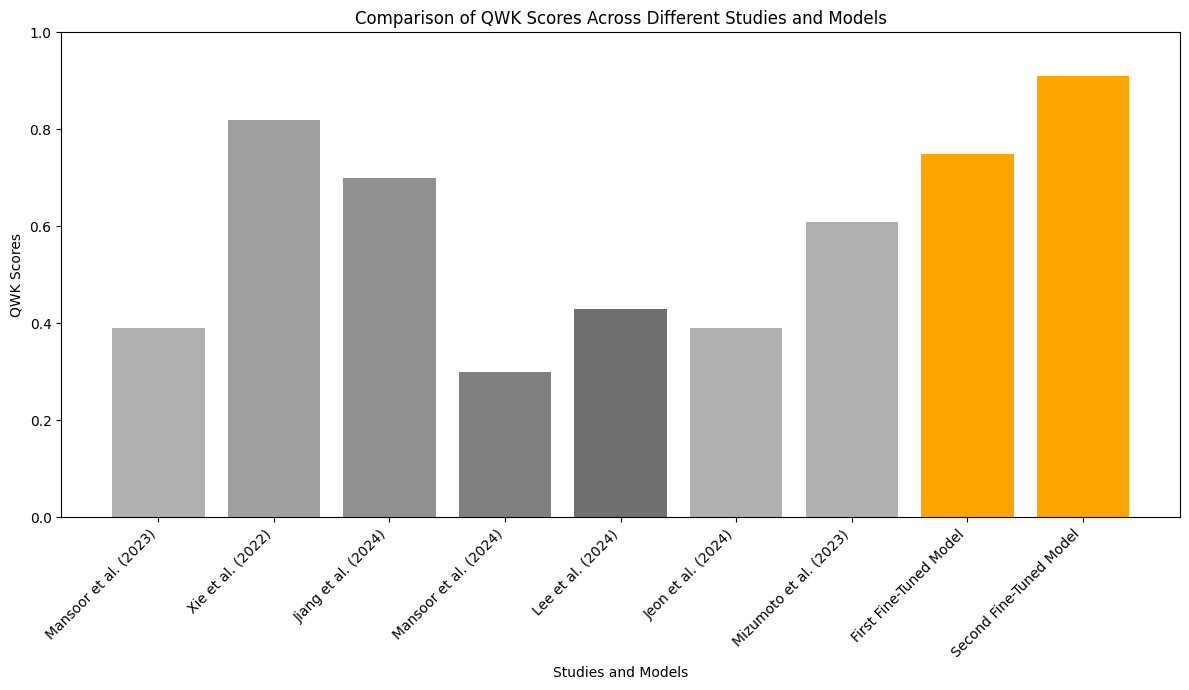

In [6]:
import matplotlib.pyplot as plt

# Data
authors = ['Mansoor et al. (2023)', 'Xie et al. (2022)', 'Jiang et al. (2024)', 
           'Mansoor et al. (2024)', 'Lee et al. (2024)', 
           'Jeon et al. (2024)', 'Mizumoto et al. (2023)', 
           'First Fine-Tuned Model', 'Second Fine-Tuned Model']
qwk_scores = [0.39, 0.82, 0.70, 0.30, 0.43, 0.39, 0.61, 0.75, 0.91]

# Colors: Shades of gray for other studies, same color for fine-tuned models
colors = ['#B0B0B0', '#A0A0A0', '#909090', '#808080', '#707070', 
          '#B0B0B0', '#B0B0B1', '#FFA500', '#FFA500']

# Plotting the graph
plt.figure(figsize=(12, 7))
plt.bar(authors, qwk_scores, color=colors)

# Adding labels and title
plt.xlabel('Studies and Models')
plt.ylabel('QWK Scores')
plt.title('Comparison of QWK Scores Across Different Studies and Models')
plt.ylim([0, 1])

# Display the graph
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
